# Scorecard bins using woebin() 

ChiMerge (Chi-Square-based binning) — default in most implementations

1. It starts by treating every unique value as its own bin.
2. Then, it iteratively merges adjacent bins that have similar default rates using the Chi-square test of independence.
3. The goal: find bins that are statistically different in terms of default behavior.

It stops merging when:
* The Chi-square statistic exceeds a threshold (significant difference), or
* The maximum number of bins is reached, or
* Merging no longer improves monotonicity.

✅ Result:
You get bins that separate good vs bad customers most distinctly, which leads to better Weight of Evidence (WOE) transformation.

In [2]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import warnings

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

In [3]:
df = pd.read_csv("merged_applicant_and_bureau_cleaned_2.csv")


In [4]:
df = df[[
    "TARGET",
    "AMT_CREDIT",
    'YEARS_EMPLOYED',
    "DEBT_RATIO",
    'AMT_CREDIT_SUM_DEBT_sum',
    'AGE',
    "CREDIT_ACTIVE_Active",
    'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE'
]]

In [5]:
df.isnull().sum()


TARGET                         0
AMT_CREDIT                     0
YEARS_EMPLOYED             47945
DEBT_RATIO                 98302
AMT_CREDIT_SUM_DEBT_sum    98302
AGE                            0
CREDIT_ACTIVE_Active       98302
NAME_INCOME_TYPE               0
OCCUPATION_TYPE            81149
dtype: int64

In [6]:
# Fill numeric columns with 0
df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
df['AMT_CREDIT_SUM_DEBT_sum'] = df['AMT_CREDIT_SUM_DEBT_sum'].fillna(0)
df['CREDIT_ACTIVE_Active'] = df['CREDIT_ACTIVE_Active'].fillna(0)
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)

# Fill OCCUPATION_TYPE with 'MISSING'
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('MISSING')

# Verify no missing values remain
print(df.isnull().sum())

TARGET                     0
AMT_CREDIT                 0
YEARS_EMPLOYED             0
DEBT_RATIO                 0
AMT_CREDIT_SUM_DEBT_sum    0
AGE                        0
CREDIT_ACTIVE_Active       0
NAME_INCOME_TYPE           0
OCCUPATION_TYPE            0
dtype: int64


In [7]:
train, test = sc.split_df(df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

(178050, 9)
(76308, 9)


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\split_df.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=ratio[0], random_state=seed))\


In [8]:
# automatically calculate bin ranges, bins is a dictionary
bins = sc.woebin(train, y = 'TARGET')

for variables, bindetails in bins.items():
    print(variables, " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer fo

AMT_CREDIT_SUM_DEBT_sum  : 


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index()\
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index()\
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:425: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the group

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",156394,0.878371,145323,11071,0.070789,-0.078425,0.005226,0.037623,8000.0,False
1,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,44000.0)",11843,0.066515,10620,1223,0.103268,0.334772,0.008594,0.037623,44000.0,False
2,AMT_CREDIT_SUM_DEBT_sum,"[44000.0,inf)",9813,0.055114,8553,1260,0.128401,0.581034,0.023803,0.037623,inf,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Businessman%,%Student%,%State servant",12850,0.072171,12173,677,0.052685,-0.393100,0.009455,0.047357,"Businessman%,%Student%,%State servant",False
1,NAME_INCOME_TYPE,Pensioner,33585,0.188627,31707,1878,0.055918,-0.330126,0.017891,0.047357,Pensioner,False
2,NAME_INCOME_TYPE,Commercial associate,40595,0.227998,37771,2824,0.069565,-0.097183,0.002067,0.047357,Commercial associate,False
3,NAME_INCOME_TYPE,"Working%,%Unemployed%,%Maternity leave",91020,0.511205,82845,8175,0.089815,0.180314,0.017944,0.047357,"Working%,%Unemployed%,%Maternity leave",False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,"Accountants%,%HR staff%,%Core staff",20708,0.116304,19629,1079,0.052105,-0.404769,0.016078,0.070432,"Accountants%,%HR staff%,%Core staff",False
1,OCCUPATION_TYPE,"Secretaries%,%Managers%,%High skill tech staff...",84214,0.472980,78921,5293,0.062852,-0.205858,0.018375,0.070432,"Secretaries%,%Managers%,%High skill tech staff...",False
2,OCCUPATION_TYPE,"Sales staff%,%Cooking staff%,%Realty agents%,%...",73128,0.410716,65946,7182,0.098211,0.278946,0.035979,0.070432,"Sales staff%,%Cooking staff%,%Realty agents%,%...",False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,0.5)",38526,0.216377,36153,2373,0.061595,-0.227400,0.010165,0.083439,0.5,False
1,YEARS_EMPLOYED,"[0.5,4.0)",53333,0.299539,47813,5520,0.103501,0.337285,0.039326,0.083439,4.0,False
2,YEARS_EMPLOYED,"[4.0,8.5)",41802,0.234777,38520,3282,0.078513,0.033480,0.000267,0.083439,8.5,False
3,YEARS_EMPLOYED,"[8.5,15.0)",28141,0.158051,26493,1648,0.058562,-0.281114,0.011095,0.083439,15.0,False
4,YEARS_EMPLOYED,"[15.0,inf)",16248,0.091255,15517,731,0.044990,-0.559073,0.022586,0.083439,inf,False


----------------------------------------------------------------------------------------------------
DEBT_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_RATIO,"[-inf,0.22)",162870,0.914743,151244,11626,0.071382,-0.069446,0.004284,0.039354,0.22,False
1,DEBT_RATIO,"[0.22,inf)",15180,0.085257,13252,1928,0.127009,0.568539,0.035070,0.039354,inf,False


----------------------------------------------------------------------------------------------------
CREDIT_ACTIVE_Active  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CREDIT_ACTIVE_Active,"[-inf,1.0)",129838,0.729222,120666,9172,0.070642,-0.080666,0.004586,0.020565,1.0,False
1,CREDIT_ACTIVE_Active,"[1.0,2.0)",34428,0.193361,31538,2890,0.083943,0.106268,0.002284,0.020565,2.0,False
2,CREDIT_ACTIVE_Active,"[2.0,inf)",13784,0.077416,12292,1492,0.108241,0.387373,0.013695,0.020565,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",9684,0.054389,9137,547,0.056485,-0.319434,0.004852,0.048077,150000.0,False
1,AMT_CREDIT,"[150000.0,300000.0)",36321,0.203993,33590,2731,0.075191,-0.013356,0.000036,0.048077,300000.0,False
2,AMT_CREDIT,"[300000.0,650000.0)",59434,0.333805,53862,5572,0.093751,0.227533,0.019035,0.048077,650000.0,False
3,AMT_CREDIT,"[650000.0,1100000.0)",49028,0.275361,45543,3485,0.071082,-0.073984,0.001461,0.048077,1100000.0,False
4,AMT_CREDIT,"[1100000.0,1350000.0)",13075,0.073434,12297,778,0.059503,-0.264180,0.004585,0.048077,1350000.0,False
5,AMT_CREDIT,"[1350000.0,inf)",10508,0.059017,10067,441,0.041968,-0.631769,0.018108,0.048077,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,39.0)",51545,0.289497,46523,5022,0.097429,0.270086,0.023686,0.054217,39.0,False
1,AGE,"[39.0,53.0)",73605,0.413395,68015,5590,0.075946,-0.002544,0.000003,0.054217,53.0,False
2,AGE,"[53.0,57.0)",19916,0.111856,18708,1208,0.060655,-0.243781,0.005998,0.054217,57.0,False
3,AGE,"[57.0,inf)",32984,0.185251,31250,1734,0.052571,-0.395384,0.024530,0.054217,inf,False


----------------------------------------------------------------------------------------------------


In [9]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,AMT_CREDIT_SUM_DEBT_sum_woe,NAME_INCOME_TYPE_woe,OCCUPATION_TYPE_woe,YEARS_EMPLOYED_woe,DEBT_RATIO_woe,CREDIT_ACTIVE_Active_woe,AMT_CREDIT_woe,AGE_woe
0,0,-0.078425,-0.393100,-0.404769,0.337285,-0.069446,-0.080666,-0.264180,-0.002544
1,0,-0.078425,0.180314,0.278946,0.337285,-0.069446,-0.080666,-0.319434,-0.002544
3,0,-0.078425,0.180314,-0.404769,0.033480,-0.069446,-0.080666,0.227533,-0.243781
5,0,-0.078425,-0.097183,-0.404769,-0.281114,-0.069446,-0.080666,-0.631769,0.270086
6,0,-0.078425,-0.393100,-0.205858,0.337285,-0.069446,-0.080666,-0.631769,-0.002544
...,...,...,...,...,...,...,...,...,...
254350,0,-0.078425,-0.097183,0.278946,0.337285,-0.069446,-0.080666,-0.013356,0.270086
254352,0,-0.078425,-0.097183,-0.404769,0.337285,-0.069446,-0.080666,0.227533,0.270086
254353,0,-0.078425,0.180314,0.278946,-0.559073,-0.069446,-0.080666,0.227533,-0.002544
254354,0,-0.078425,-0.330126,-0.205858,-0.227400,-0.069446,-0.080666,-0.013356,-0.243781


In [10]:
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

#THIS NOT THE RIGHT THING TO DO I THINK 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept                     -0.000286
AMT_CREDIT_SUM_DEBT_sum_woe    0.371295
NAME_INCOME_TYPE_woe           0.192980
OCCUPATION_TYPE_woe            0.646164
YEARS_EMPLOYED_woe             0.668227
DEBT_RATIO_woe                 0.491773
CREDIT_ACTIVE_Active_woe       0.283437
AMT_CREDIT_woe                 0.835809
AGE_woe                        0.450238
dtype: float64

In [11]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
# align target odds with probabity of default = 7.6% 
# odds = p/(1-p) = 0.076/(1-0.076) = 0.0825 ~= 1/12
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/13, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':    variable          bin  points
26      AGE  [-inf,39.0)    62.0
27      AGE  [39.0,53.0)    66.0
28      AGE  [53.0,57.0)    69.0
29      AGE   [57.0,inf)    71.0,
 'AMT_CREDIT':       variable                    bin  points
20  AMT_CREDIT        [-inf,150000.0)    73.0
21  AMT_CREDIT    [150000.0,300000.0)    66.0
22  AMT_CREDIT    [300000.0,650000.0)    60.0
23  AMT_CREDIT   [650000.0,1100000.0)    68.0
24  AMT_CREDIT  [1100000.0,1350000.0)    72.0
25  AMT_CREDIT        [1350000.0,inf)    81.0,
 'AMT_CREDIT_SUM_DEBT_sum':                   variable               bin  points
0  AMT_CREDIT_SUM_DEBT_sum     [-inf,8000.0)    67.0
1  AMT_CREDIT_SUM_DEBT_sum  [8000.0,44000.0)    62.0
2  AMT_CREDIT_SUM_DEBT_sum     [44000.0,inf)    60.0,
 'CREDIT_ACTIVE_Active':                 variable         bin  points
17  CREDIT_ACTIVE_Active  [-inf,1.0)    66.0
18  CREDIT_ACTIVE_Active   [1.0,2.0)    65.0
19  CREDIT_ACTIVE_Active   [2.0,inf)    63.0,
 'DEBT_RATIO':       variable          bi

In [12]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# sample code

# check model performance at 1:2.67 odds of default
cutoff = 520

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))
 
print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[126229  38267]
 [  8052   5502]]
PCC measures:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84    164496
           1       0.13      0.41      0.19     13554

    accuracy                           0.74    178050
   macro avg       0.53      0.59      0.52    178050
weighted avg       0.88      0.74      0.80    178050

*** Test Data Performance ***
Confusion matrix:
[[54088 16411]
 [ 3416  2393]]
PCC measures:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     70499
           1       0.13      0.41      0.19      5809

    accuracy                           0.74     76308
   macro avg       0.53      0.59      0.52     76308
weighted avg       0.88      0.74      0.80     76308



In [13]:
train_decision = -train_score['score']
test_decision  = -test_score['score']

Train AUC: 0.629
Test  AUC: 0.631


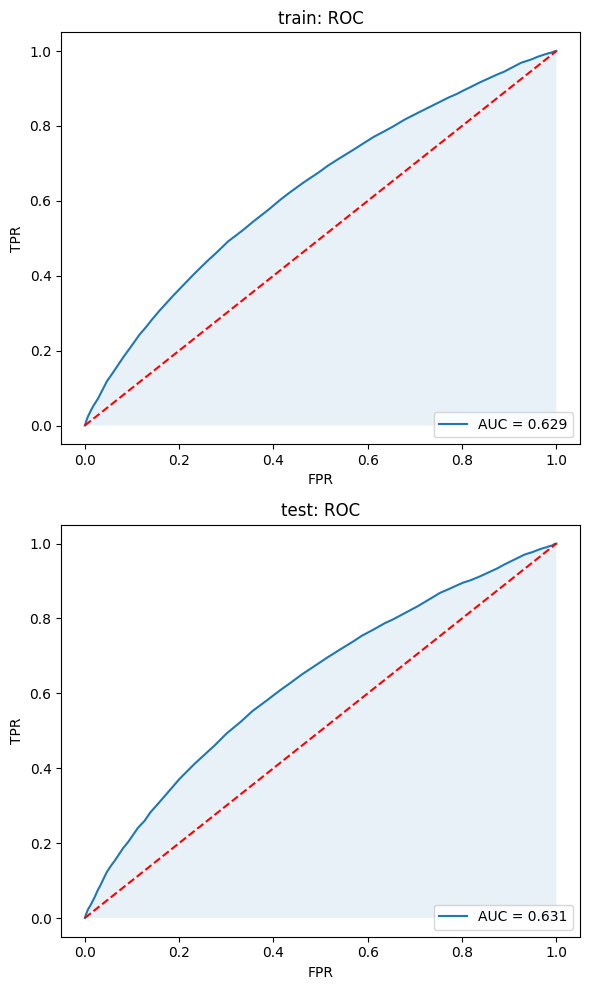

In [14]:
train_decision = -train_score
test_decision  = -test_score

# --- Compute ROC and AUC for train ---
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, train_decision)
auc_train = metrics.roc_auc_score(y_train, train_decision)

# --- Compute ROC and AUC for test ---
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, test_decision)
auc_test = metrics.roc_auc_score(y_test, test_decision)

print(f"Train AUC: {auc_train:.3f}")
print(f"Test  AUC: {auc_test:.3f}")

# --- Plot ROC curves (train + test) ---
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Train ROC
axes[0].plot(fpr_train, tpr_train, label=f"AUC = {auc_train:.3f}")
axes[0].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[0].set_title("train: ROC")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].fill_between(fpr_train, tpr_train, alpha=0.1)
axes[0].legend(loc="lower right")

# Test ROC
axes[1].plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.3f}")
axes[1].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[1].set_title("test: ROC")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].fill_between(fpr_test, tpr_test, alpha=0.1)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [15]:
# combine all variable tables into one big dataframe
card_df = pd.concat(card.values(), ignore_index=True)

# show all rows (or set a big number)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

card_df

,variable,bin,points
0,basepoints,NaN,0.0
1,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",67.0
2,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,44000.0)",62.0
3,AMT_CREDIT_SUM_DEBT_sum,"[44000.0,inf)",60.0
4,NAME_INCOME_TYPE,"Businessman%,%Student%,%State servant",68.0
5,NAME_INCOME_TYPE,Pensioner,68.0
6,NAME_INCOME_TYPE,Commercial associate,66.0
7,NAME_INCOME_TYPE,"Working%,%Unemployed%,%Maternity leave",65.0
8,OCCUPATION_TYPE,"Accountants%,%HR staff%,%Core staff",73.0
9,OCCUPATION_TYPE,"Secretaries%,%Managers%,%High skill tech staff%,%Medicine staff%,%Private service staff%,%MISSING%,%IT staff",70.0


In [ ]:
def first_at_cutoff(cutoff, df, scores, actuals):
    """
    Print the first borrower whose score is exactly at the cutoff.
    
    Parameters:
    - cutoff: score cutoff to predict GOOD
    - df: original DataFrame containing borrower info
    - scores: Series or single-column DataFrame with scores
    - actuals: Series or single-column DataFrame with actual labels
    """
    # Flatten if DataFrame
    if isinstance(scores, pd.DataFrame):
        scores = scores.iloc[:, 0]
    if isinstance(actuals, pd.DataFrame):
        actuals = actuals.iloc[:, 0]

    # Find indices where score == cutoff
    cutoff_indices = df.index[scores == cutoff]
    
    if len(cutoff_indices) > 0:
        first_idx = cutoff_indices[0]
        print(f"First borrower at cutoff score {cutoff}:")
        print(df.loc[first_idx])  # full row with all variables
        prediction = "GOOD" if scores.loc[first_idx] >= cutoff else "BAD"
        print(f"Predicted as: {prediction}, Actual: {actuals.loc[first_idx]}")
    else:
        print(f"No borrower has exactly the cutoff score {cutoff}.")

# Example usage
first_at_cutoff(485, train_score, train_score, y_train)
